In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
df = pd.concat(
    [
        pd.read_csv('customer_churn_dataset-training-master.csv'), 
        pd.read_csv('customer_churn_dataset-testing-master.csv')
    ], 
    axis=0)
df.reset_index(drop=True, inplace=True)
df

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
505202,64370.0,45.0,Female,33.0,12.0,6.0,21.0,Basic,Quarterly,947.0,14.0,1.0
505203,64371.0,37.0,Male,6.0,1.0,5.0,22.0,Standard,Annual,923.0,9.0,1.0
505204,64372.0,25.0,Male,39.0,14.0,8.0,30.0,Premium,Monthly,327.0,20.0,1.0
505205,64373.0,50.0,Female,18.0,19.0,7.0,22.0,Standard,Monthly,540.0,13.0,1.0


In [3]:
df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000
mean,200779.451782,39.704172,31.350435,15.714825,3.833317,13.496843,620.072766,14.610581,0.555203
std,137241.343095,12.670577,17.237482,8.619323,3.133603,8.451187,245.319256,8.608286,0.496944
min,1.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,63827.250000,29.000000,16.000000,8.000000,1.000000,6.000000,446.000000,7.000000,0.000000
50%,193039.500000,40.000000,32.000000,16.000000,3.000000,13.000000,648.900000,14.000000,1.000000
75%,321645.750000,49.000000,46.000000,23.000000,6.000000,20.000000,824.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [4]:
df.describe(include=[object]) 

,Gender,Subscription Type,Contract Length
count,505206,505206,505206
unique,2,3,3
top,Male,Standard,Annual
freq,280273,170630,198608


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505207 entries, 0 to 505206
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last Interaction   505206 non-null  float64
 11  Churn              505206 non-null  float64
dtypes: float64(9), object(3)
memory usage: 46.3+ MB


# Preprocessing

In [6]:
df.drop(columns='CustomerID', inplace=True) # removing unnecessary colum

df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [7]:
df.shape

(505207, 11)

In [8]:
df.isnull().sum()

age                  1
gender               1
tenure               1
usage_frequency      1
support_calls        1
payment_delay        1
subscription_type    1
contract_length      1
total_spend          1
last_interaction     1
churn                1
dtype: int64

In [9]:
df[df.isna().any(axis=1)]

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(505206, 11)

In [12]:
descrete_col = ['age', 'tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'last_interaction', 'churn']
for col in descrete_col:
    df[col] = df[col].astype(int)
df

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,30,Female,39,14,5,18,Standard,Annual,932.0,17,1
1,65,Female,49,1,10,8,Basic,Monthly,557.0,6,1
2,55,Female,14,4,6,18,Basic,Quarterly,185.0,3,1
3,58,Male,38,21,7,7,Standard,Monthly,396.0,29,1
4,23,Male,32,20,5,8,Basic,Monthly,617.0,20,1
...,...,...,...,...,...,...,...,...,...,...,...
505202,45,Female,33,12,6,21,Basic,Quarterly,947.0,14,1
505203,37,Male,6,1,5,22,Standard,Annual,923.0,9,1
505204,25,Male,39,14,8,30,Premium,Monthly,327.0,20,1
505205,50,Female,18,19,7,22,Standard,Monthly,540.0,13,1


## Univarient Analysis

In [13]:
# Creating custom functions to visualize features

def make_histogram(df, target_feature, bins = 10, custom_ticks=None, unit='', additional=''):
    plt.figure(figsize=(10, 5))
    plt.hist(df[target_feature], bins=bins)
    if custom_ticks is not None:
        plt.xticks(custom_ticks)
    plt.ylabel('Count')
    plt.xlabel(target_feature)
    plt.title(f"Distribution of {target_feature.lower()}{additional}:\n")
    plt.grid()
    plt.show()
    print(f"Distribution of {target_feature.lower()}{additional}: {df[target_feature].mean():.2f} ± {df[target_feature].median():.2f} {unit}\nMedian: {df[target_feature].median():.2f} {unit}\nMinimum: {df[target_feature].min()} {unit}\nMaximum: {df[target_feature].max()} {unit}\n{df[target_feature].skew():.3f} Skewness\n")

def make_piechart(df, target_feature, additional=''):
    dict_of_val_counts = dict(df[target_feature].value_counts())
    data = list(dict_of_val_counts.values())
    keys = list(dict_of_val_counts.keys())
    
    palette_color = sns.color_palette('bright')
    plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
    plt.title(f"Distribution of Cutomer's {target_feature}:")
    plt.show()
    print_str = f"Distribution of cutomer's {target_feature.lower()}{additional}:"
    for k, v in zip(keys, data):
        print_str += f"\n{v} {k}"
    print(print_str)

def make_barplot(df, target_feature, custom_ticks=None, unit='', additional=''):
    plt.figure(figsize=(10, 5))
    dict_of_val_counts = dict(df[target_feature].value_counts())
    data = list(dict_of_val_counts.values())
    keys = list(dict_of_val_counts.keys())
    plt.bar(keys, data)
    if custom_ticks is not None:
        plt.xticks(custom_ticks)
    plt.xlabel(f'{target_feature.capitalize()}{additional}')
    plt.ylabel('Frequency')
    plt.title(f"Distribution of cutomer's {target_feature.lower()}{additional}\n")
    plt.grid(axis='y')
    plt.show()
    print(f"Distribution of cutomer's {target_feature.lower()}{additional}: {df[target_feature].mean():.2f} ± {df[target_feature].median():.2f} {unit}\nMedian: {df[target_feature].median():.2f} {unit}\nMinimum: {df[target_feature].min()} {unit}\nMaximum: {df[target_feature].max()} {unit}\n\n{df[target_feature].skew():.3f} Skewness\n")
    
def make_boxplot(df, feature):
    plt.figure(figsize=(10,5))
    sns.boxplot(df, x=feature)
    plt.title(f"Boxplot of {feature}\n")
    plt.xlabel(feature)
    plt.ylabel("Values")
    plt.show()

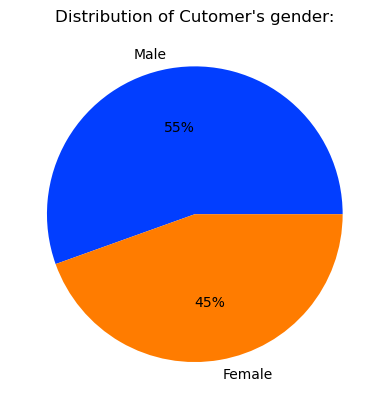

Distribution of cutomer's gender:
280273 Male
224933 Female


In [14]:
make_piechart(df, 'gender')

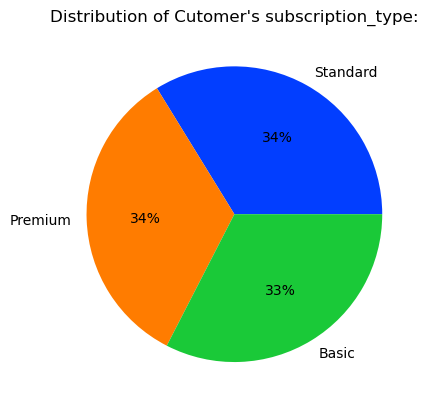

Distribution of cutomer's subscription_type:
170630 Standard
170099 Premium
164477 Basic


In [15]:
make_piechart(df, 'subscription_type')

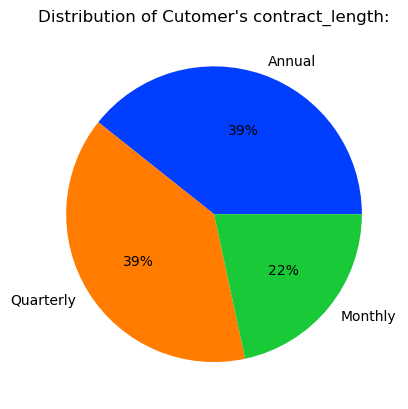

Distribution of cutomer's contract_length:
198608 Annual
197364 Quarterly
109234 Monthly


In [16]:
make_piechart(df, 'contract_length')

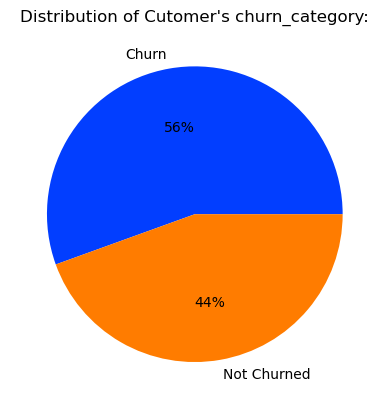

Distribution of cutomer's churn_category:
280492 Churn
224714 Not Churned


In [17]:
filtered = df.copy()
filtered['churn_category'] = ['Churn' if x == 1.0 else 'Not Churned' for x in df['churn']]
make_piechart(filtered, 'churn_category')

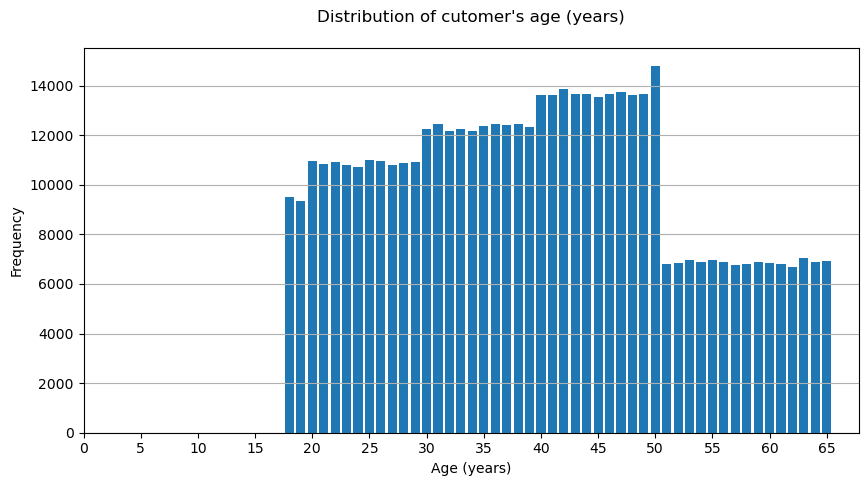

Distribution of cutomer's age (years): 39.70 ± 40.00 years
Median: 40.00 years
Minimum: 18 years
Maximum: 65 years

0.144 Skewness



In [18]:
make_barplot(df, 'age', custom_ticks=np.arange(0, 66, 5), additional=' (years)', unit='years')

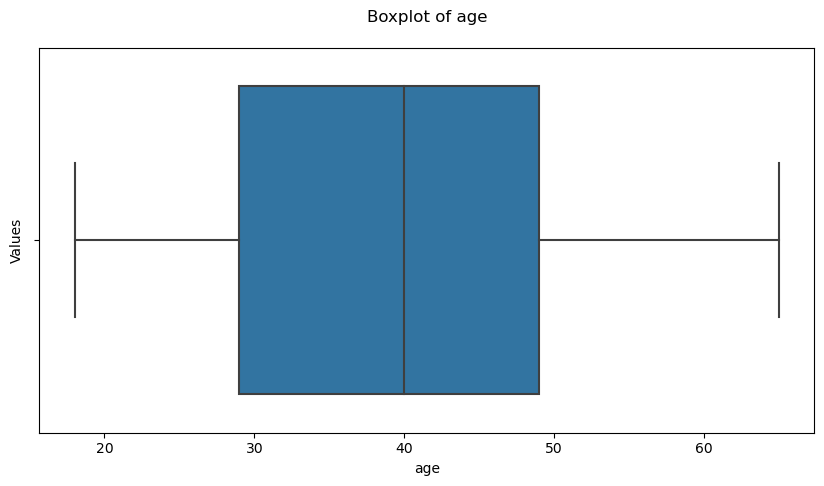

In [19]:
make_boxplot(df, 'age')

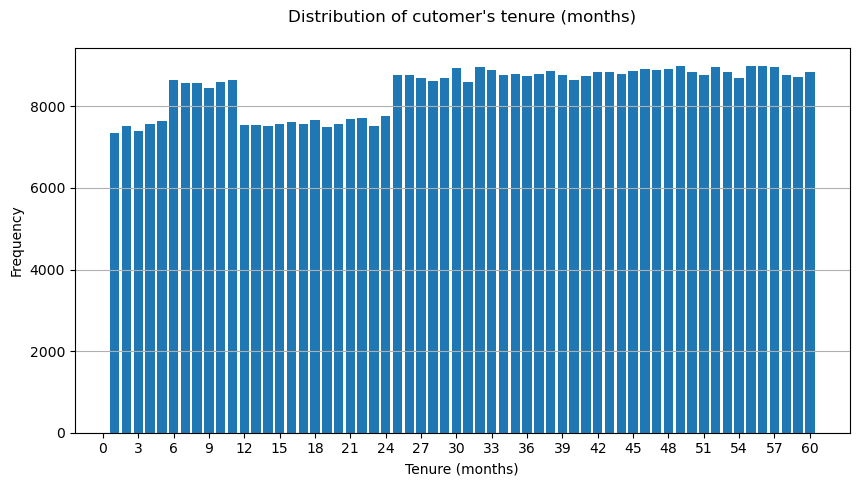

Distribution of cutomer's tenure (months): 31.35 ± 32.00 months
Median: 32.00 months
Minimum: 1 months
Maximum: 60 months

-0.070 Skewness



In [20]:
make_barplot(df, 'tenure', custom_ticks=np.arange(0, 61, 3), additional=' (months)', unit='months')

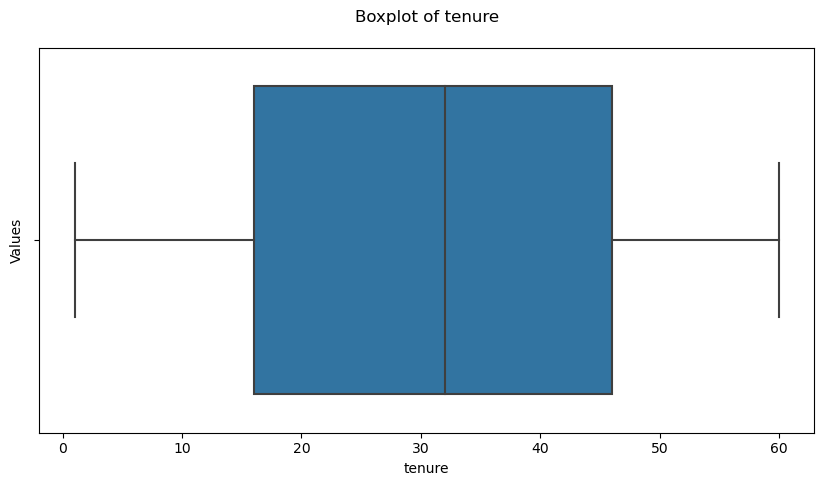

In [21]:
make_boxplot(df, 'tenure')

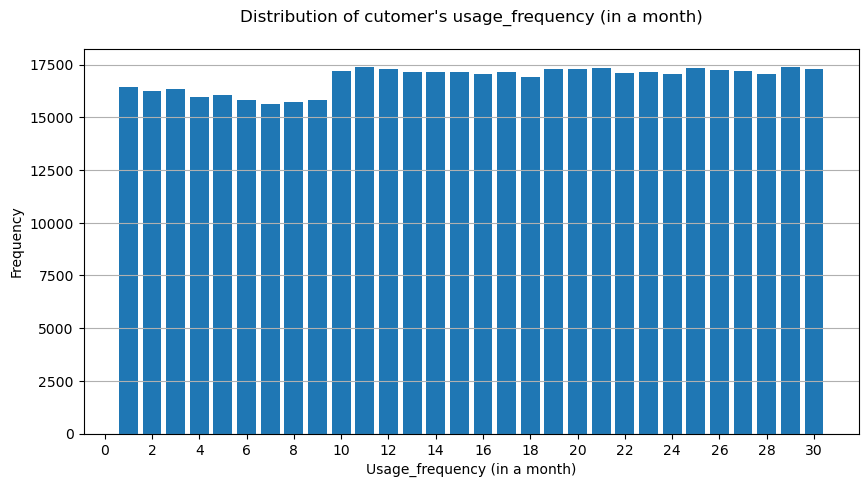

Distribution of cutomer's usage_frequency (in a month): 15.71 ± 16.00 times
Median: 16.00 times
Minimum: 1 times
Maximum: 30 times

-0.034 Skewness



In [22]:
make_barplot(df, 'usage_frequency', custom_ticks=np.arange(0, 31, 2), unit='times', additional=' (in a month)')

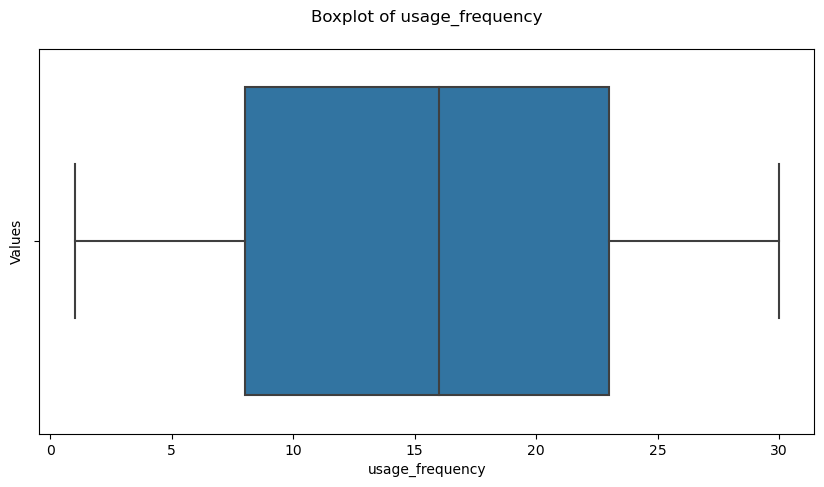

In [23]:
make_boxplot(df, 'usage_frequency')

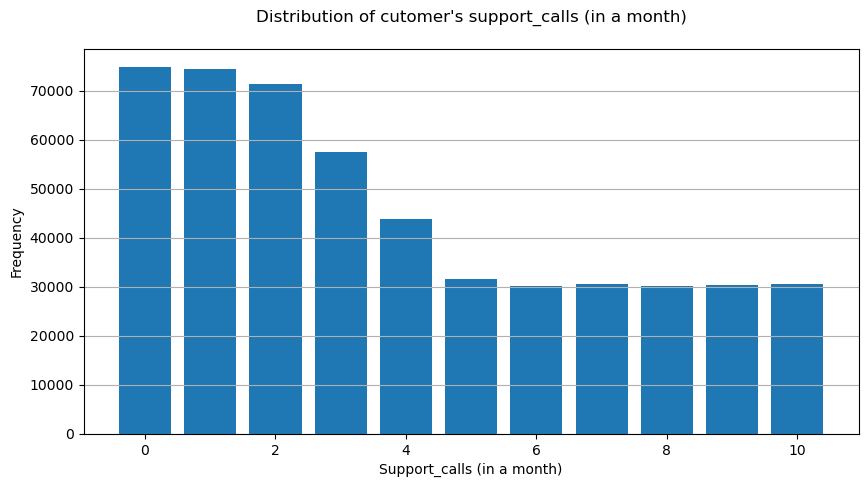

Distribution of cutomer's support_calls (in a month): 3.83 ± 3.00 calls
Median: 3.00 calls
Minimum: 0 calls
Maximum: 10 calls

0.544 Skewness



In [24]:
make_barplot(df, 'support_calls', unit='calls', additional=' (in a month)')

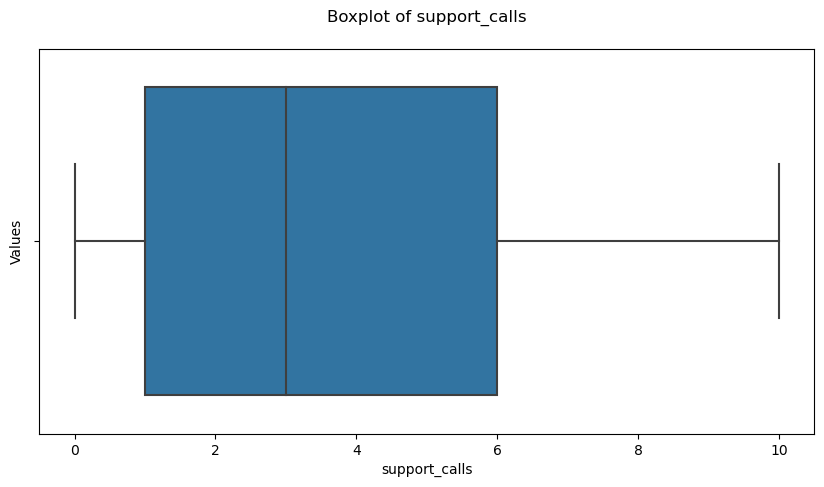

In [25]:
make_boxplot(df, 'support_calls')

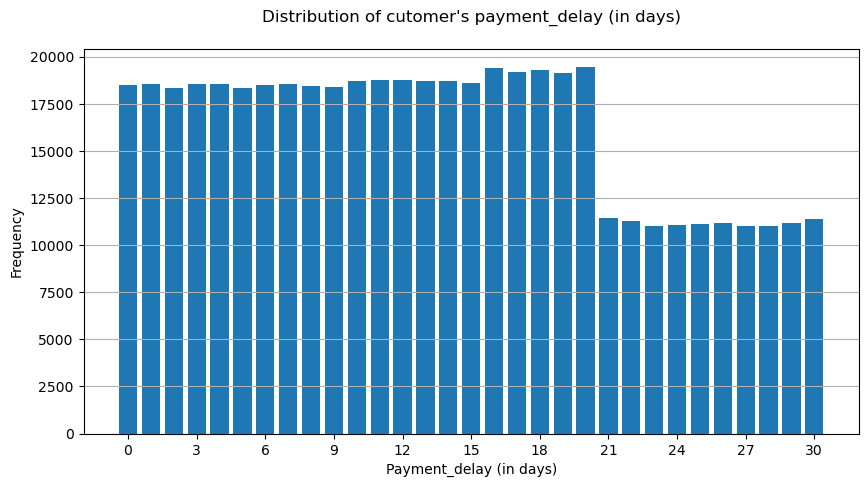

Distribution of cutomer's payment_delay (in days): 13.50 ± 13.00 days
Median: 13.00 days
Minimum: 0 days
Maximum: 30 days

0.200 Skewness



In [26]:
make_barplot(df, 'payment_delay', custom_ticks=np.arange(0, 32, 3), unit='days', additional=' (in days)')

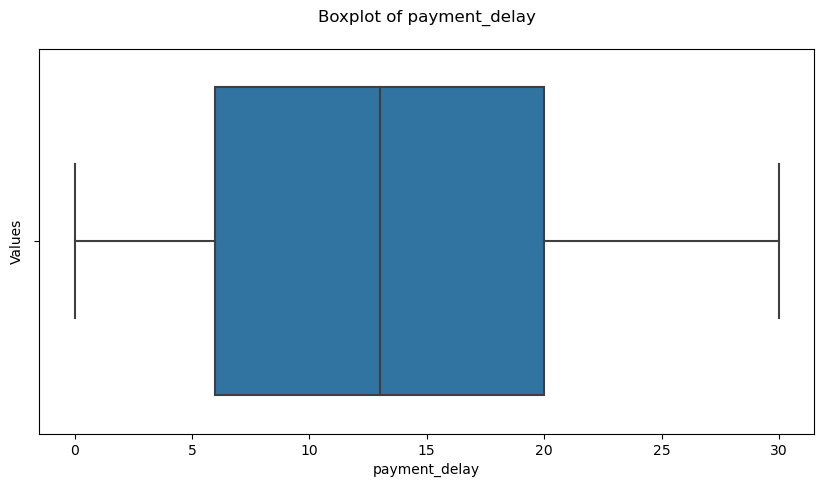

In [27]:
make_boxplot(df, 'payment_delay')

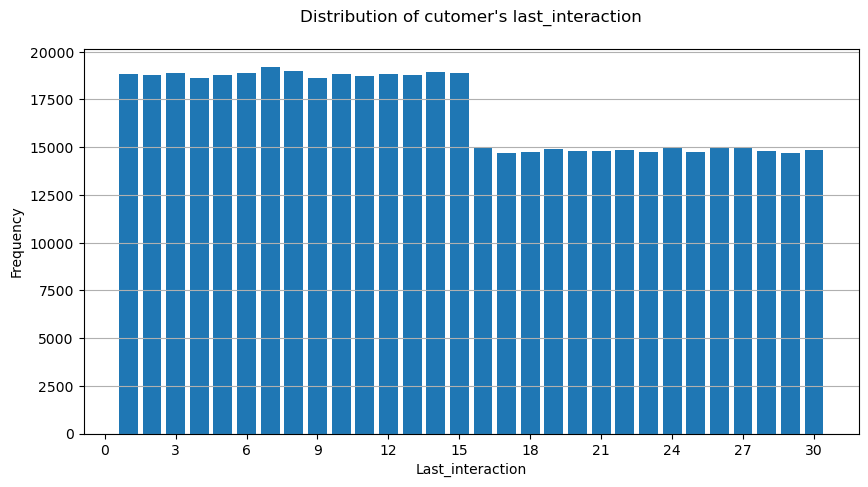

Distribution of cutomer's last_interaction: 14.61 ± 14.00 days
Median: 14.00 days
Minimum: 1 days
Maximum: 30 days

0.155 Skewness



In [28]:
make_barplot(df, 'last_interaction', custom_ticks=np.arange(0, 32, 3), unit='days', additional='')

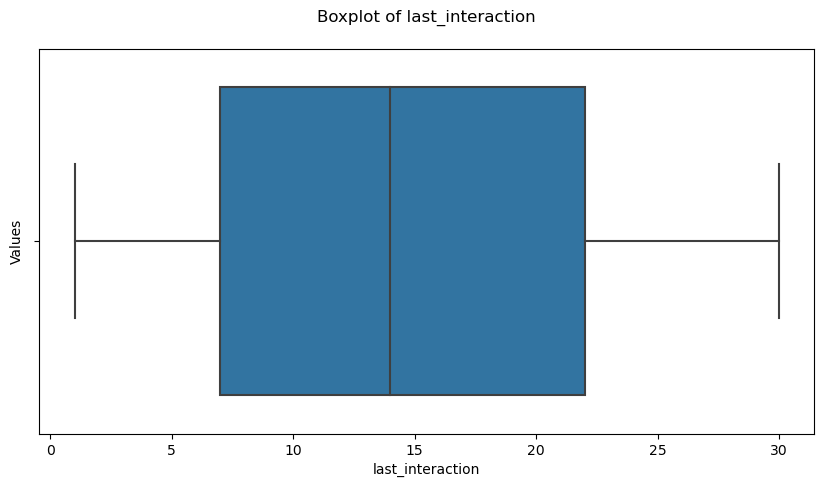

In [29]:
make_boxplot(df, 'last_interaction')

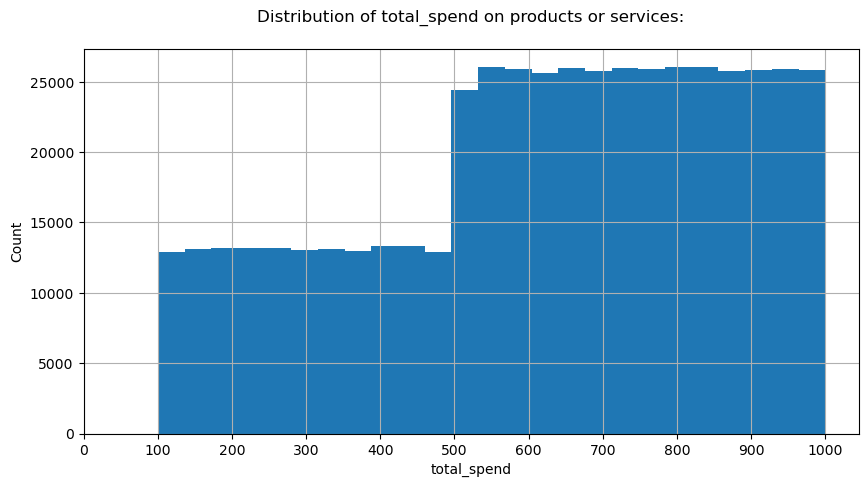

Distribution of total_spend on products or services: 620.07 ± 648.90 USD
Median: 648.90 USD
Minimum: 100.0 USD
Maximum: 1000.0 USD
-0.395 Skewness



In [30]:
make_histogram(df, 'total_spend', bins=25, custom_ticks=np.arange(0, 1001, 100), 
    unit='USD', additional=" on products or services")

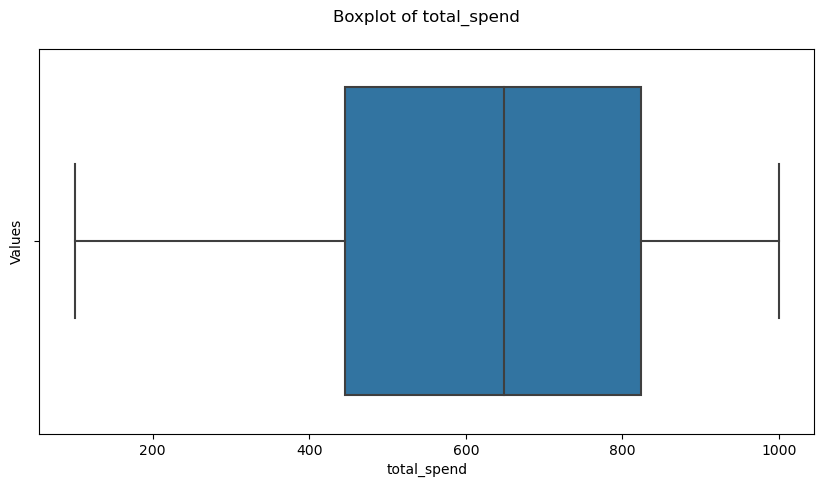

In [31]:
make_boxplot(df, 'total_spend')

## Multivariate Analysis

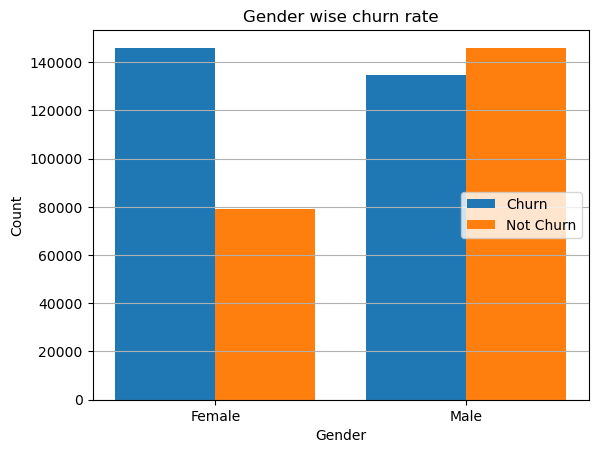

In [32]:
gender_churn = df.groupby(['gender', 'churn']).size().unstack()

X = list(gender_churn.index)
churn_0 = list(gender_churn.iloc[:, 0])
churn_1 = list(gender_churn.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')

plt.xticks(X_axis, X)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title("Gender wise churn rate")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

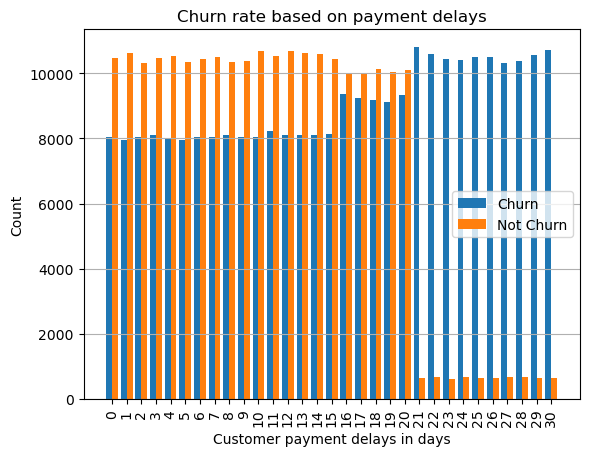

In [33]:
filtered = df.groupby(['payment_delay', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')

plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Customer payment delays in days")
plt.ylabel('Count')
plt.title("Churn rate based on payment delays")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

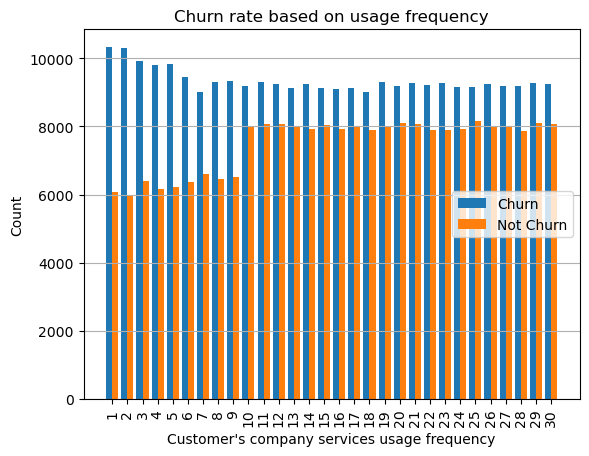

In [34]:
filtered = df.groupby(['usage_frequency', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')

plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Customer's company services usage frequency")
plt.ylabel('Count')
plt.title("Churn rate based on usage frequency")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

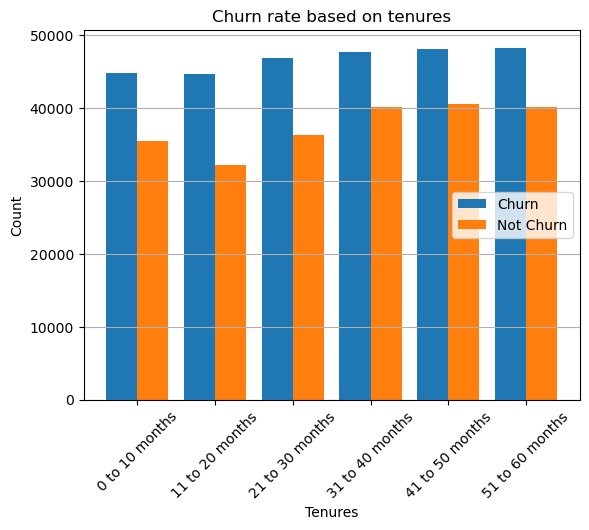

In [35]:
def categorize_age(age):
    if 0 <= age <= 10:
        return '0 to 10 months'
    elif 11 <= age <= 20:
        return '11 to 20 months'
    elif 21 <= age <= 30:
        return '21 to 30 months'
    elif 31 <= age <= 40:
        return '31 to 40 months'
    elif 41 <= age <= 50:
        return '41 to 50 months'
    elif 51 <= age <= 60:
        return '51 to 60 months'
    else:
        pass # For nan values

filtered = df.copy()
filtered['tenure_segmentation'] = df['tenure'].apply(categorize_age)
filtered = filtered.groupby(['tenure_segmentation', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')

plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Tenures')
plt.ylabel('Count')
plt.title("Churn rate based on tenures")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

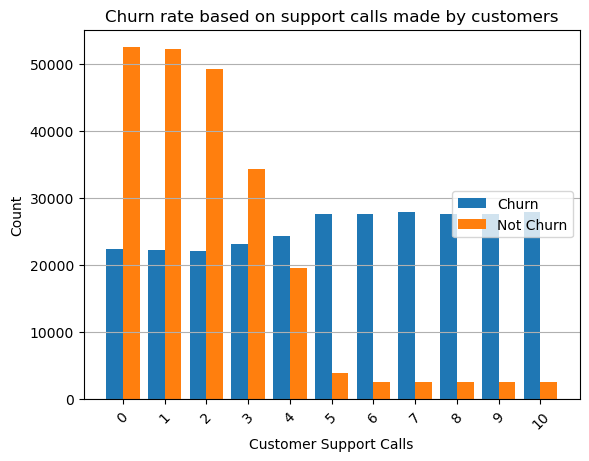

In [36]:
filtered = df.groupby(['support_calls', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')

plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Customer Support Calls')
plt.ylabel('Count')
plt.title("Churn rate based on support calls made by customers")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

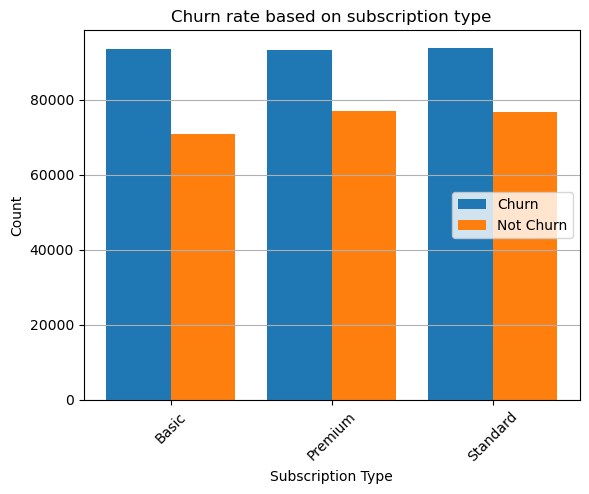

In [37]:
filtered = df.groupby(['subscription_type', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')

plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Subscription Type')
plt.ylabel('Count')
plt.title("Churn rate based on subscription type")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

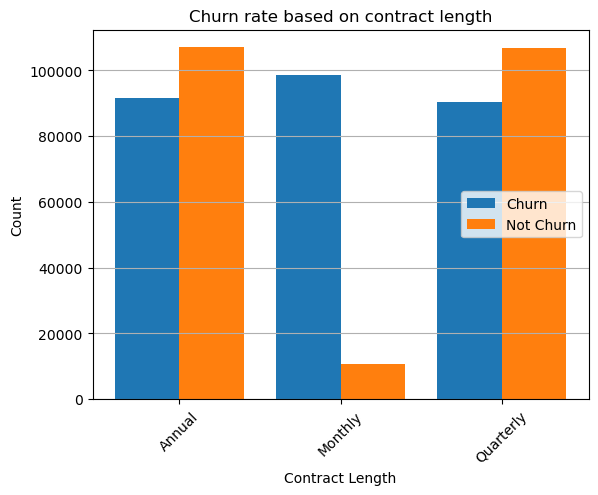

In [38]:
filtered = df.groupby(['contract_length', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')

plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Contract Length')
plt.ylabel('Count')
plt.title("Churn rate based on contract length")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

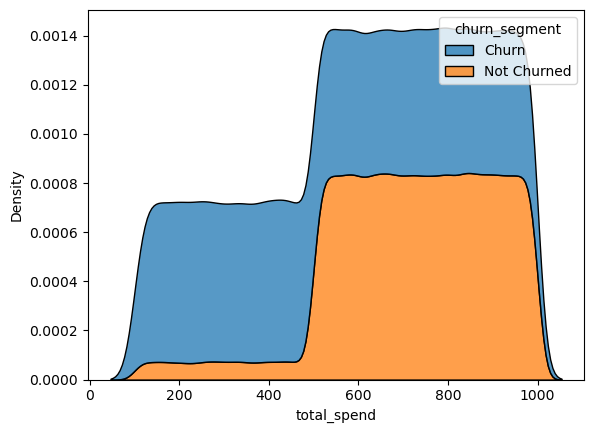

In [39]:
filtered = df.copy()
filtered['churn_segment'] = ['Churn' if x == 1.0 else 'Not Churned' for x in df['churn']]

sns.kdeplot(data=filtered, x="total_spend", hue="churn_segment", multiple="stack")
plt.show()

# Data Preprocessing

In [40]:
independent_features_df = df.select_dtypes(include=['number']).copy().drop(columns=['churn'])

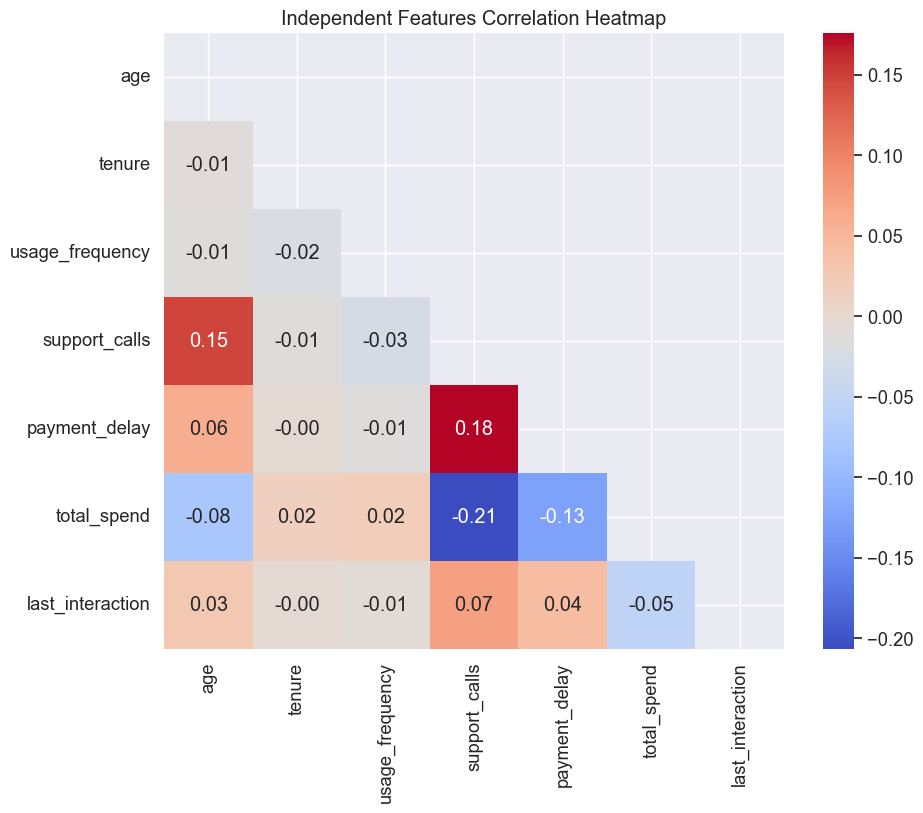

In [41]:
corr_matrix = independent_features_df.corr()

# Creating a mask to hide the upper triangle of the heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Independent Features Correlation Heatmap")
plt.show()

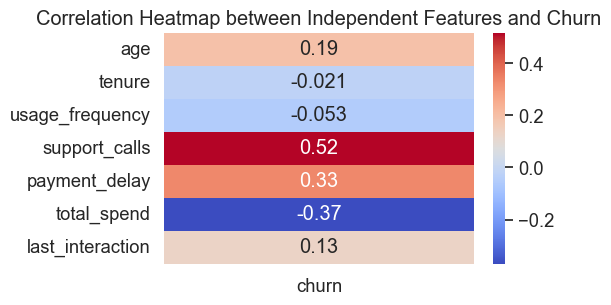

In [42]:
correlation_data = df.select_dtypes(include=['number']).corr().loc[:'last_interaction', 'churn']


# Create a heatmap
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.2)
sns.heatmap(correlation_data.to_frame(), annot=True, cmap="coolwarm", cbar=True)

plt.title("Correlation Heatmap between Independent Features and Churn")
plt.show()

In [43]:
df[df.duplicated()]

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn


## Train and test Split

In [44]:
y = df['churn']
X = df.drop(columns='churn')

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

# Reset the index of the resulting DataFrames
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [46]:
X_train

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
0,52,Female,38,25,0,15,Basic,Quarterly,471.00,15
1,41,Male,46,12,1,0,Basic,Quarterly,913.53,17
2,45,Male,34,23,2,20,Premium,Annual,884.23,17
3,43,Male,43,22,7,14,Premium,Quarterly,262.00,27
4,65,Female,40,18,1,19,Premium,Annual,660.63,25
...,...,...,...,...,...,...,...,...,...,...
404159,28,Female,16,16,6,23,Premium,Annual,670.00,5
404160,42,Female,39,19,4,28,Premium,Quarterly,331.00,15
404161,22,Male,46,19,10,3,Standard,Quarterly,257.00,20
404162,47,Male,36,1,0,1,Basic,Annual,788.78,24


In [47]:
X_test

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
0,53,Female,28,19,1,10,Standard,Monthly,647.00,25
1,35,Female,17,8,5,20,Basic,Monthly,433.00,29
2,46,Male,53,28,4,7,Basic,Annual,755.16,15
3,32,Female,18,22,2,25,Standard,Quarterly,536.15,24
4,40,Female,17,12,3,20,Standard,Quarterly,951.32,9
...,...,...,...,...,...,...,...,...,...,...
101037,60,Male,48,6,0,14,Standard,Quarterly,326.00,12
101038,39,Male,23,13,3,19,Standard,Quarterly,757.30,4
101039,32,Female,36,16,0,18,Premium,Annual,778.90,12
101040,21,Male,37,10,1,10,Basic,Quarterly,831.35,1


In [48]:
def validate_test_data_categorical_columns(train_df, test_df):
    # Get the list of categorical columns for both train and test DataFrames
    train_df_categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
    test_df_categorical_columns = test_df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Check if the number of categorical columns is the same in both DataFrames
    if len(set(train_df_categorical_columns).intersection(set(test_df_categorical_columns))) == 0:
        print('Train and test dataframes have different categorical columns')
        return
    else:
        for cat_col in test_df_categorical_columns:
            # Create sets of unique values for the current categorical column in both DataFrames
            train_col = set(x for x in train_df[cat_col].unique().tolist() if not pd.isna(x))
            test_col = set(x for x in test_df[cat_col].unique().tolist() if not pd.isna(x))
            
            # Check if the sets are not equal, indicating different unique values
            if train_col != test_col:
                print(f'{cat_col} column has different unique values in train and test data:')
                print(f'Unique values in train data: {train_col}')
                print(f'Unique values in test data: {test_col}')
                return
        
        print('All categorical columns have consistent unique values in train and test data.')
        return
    
validate_test_data_categorical_columns(X_train, X_test)

All categorical columns have consistent unique values in train and test data.


## One Hot Encoding

In [49]:
encoder = OneHotEncoder(sparse_output=False)

encoder.fit(X_train[['gender', 'subscription_type', 'contract_length']])

OneHotEncoder(sparse_output=False)

In [50]:
feature_names = encoder.get_feature_names_out(['gender', 'subscription_type', 'contract_length'])
feature_names

array(['gender_Female', 'gender_Male', 'subscription_type_Basic',
       'subscription_type_Premium', 'subscription_type_Standard',
       'contract_length_Annual', 'contract_length_Monthly',
       'contract_length_Quarterly'], dtype=object)

In [51]:
train_categorical_one_encoded_data = encoder.transform(X_train[['gender', 'subscription_type', 'contract_length']])
train_OHE_df = pd.DataFrame(train_categorical_one_encoded_data, columns=feature_names)

test_categorical_one_encoded_data = encoder.transform(X_test[['gender', 'subscription_type', 'contract_length']])
test_OHE_df = pd.DataFrame(test_categorical_one_encoded_data, columns=feature_names)

In [52]:
train_OHE_df.head(3)

,gender_Female,gender_Male,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,contract_length_Annual,contract_length_Monthly,contract_length_Quarterly
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [53]:
test_OHE_df.head(3)

,gender_Female,gender_Male,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,contract_length_Annual,contract_length_Monthly,contract_length_Quarterly
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [54]:
X_train = X_train.drop(columns=['gender', 'subscription_type', 'contract_length'])
X_test = X_test.drop(columns=['gender', 'subscription_type', 'contract_length'])

In [55]:
X_train = pd.concat([X_train, train_OHE_df], axis=1)
X_test = pd.concat([X_test, test_OHE_df], axis=1)

In [56]:
# Saving the encoder to a file
with open('encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

In [57]:
# Example Usage

with open('encoder.pkl', 'rb') as file:
    loaded_encoder = pickle.load(file)
    
loaded_encoder.transform([['Male', 'Premium', 'Monthly']])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


array([[0., 1., 0., 1., 0., 0., 1., 0.]])

In [82]:
X_train

,age,tenure,usage_frequency,support_calls,payment_delay,total_spend,last_interaction,gender_Female,gender_Male,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,contract_length_Annual,contract_length_Monthly,contract_length_Quarterly
0,52,38,25,0,15,471.00,15,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,41,46,12,1,0,913.53,17,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,45,34,23,2,20,884.23,17,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,43,43,22,7,14,262.00,27,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,65,40,18,1,19,660.63,25,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404159,28,16,16,6,23,670.00,5,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
404160,42,39,19,4,28,331.00,15,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
404161,22,46,19,10,3,257.00,20,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
404162,47,36,1,0,1,788.78,24,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [101]:
import plotly.graph_objects as go
import pandas as pd

# Displaying the head(5) of the churn dataset
df_head = X_train.head()

# Creating a Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=[col.replace("_", "<br>") for col in df_head.columns],
                fill_color='paleturquoise',
                align='center',
                font=dict(size=14),  
                height=50,  
                line=dict(width=1)),  
    cells=dict(values=[df_head[col] for col in df_head.columns],
                fill_color='lavender',
                align='center',
                height=40,  
                font=dict(size=12), 
                line=dict(width=1)),  
)])

# Setting the size and margin of the table
fig.update_layout(height=450, width=1500, margin=dict(l=0, r=0, t=50, b=0)) 
fig.update_layout(title_text='Gambar 2. Data Setelah di Preparation', title_x=0.5, title_y=0.96)

fig.show()


## PCA

In [58]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

In [59]:
# Printing the explained variance ratio
pca.explained_variance_ratio_

array([0.98871748, 0.00488704])

In [60]:
data = {
    'Feature_1': X_pca[:, 0],
    'Feature_2': X_pca[:, 1],
    'Target': y_train
}

pca_df = pd.DataFrame(data)
pca_df

,Feature_1,Feature_2,Target
0,149.198059,-6.509794,1
1,-293.426445,-14.310974,0
2,-264.013776,-2.108672,0
3,358.189340,-11.904150,1
4,-40.332599,-8.141131,1
...,...,...,...
404159,-49.831853,15.260623,0
404160,289.223933,-7.883832,1
404161,363.048168,-15.289229,0
404162,-168.620708,-4.512112,0


C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


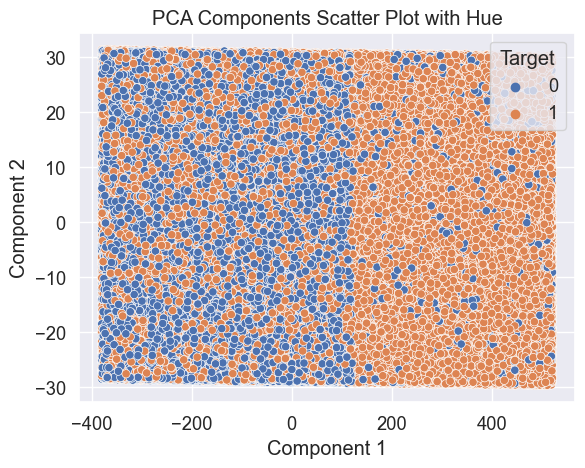

In [61]:
sns.scatterplot(data=pca_df, x='Feature_1', y='Feature_2', hue='Target')

# Set plot labels and title
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Components Scatter Plot with Hue')

# Show the plot
plt.legend(title='Target')
plt.show()

# Modelling

In [62]:
def print_evaluation_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print()
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    print()

    class_report = classification_report(y_true, y_pred)
    print("Classification Report:")
    print(class_report)

In [63]:
def k_fold_cross_validation_with_metrics(classifier, X, y, k_folds=5):
    
    # Initializing stratified k-fold cross-validation
    stratified_kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Lists to store the evaluation metrics for each fold
    accuracy_scores = []
    precision_scores = []
    recall_scores = []

    # Perform cross-validation
    for train_index, test_index in stratified_kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the classifier on the training data
        classifier.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = classifier.predict(X_test)

        # Calculate evaluation metrics for this fold
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # Append the metrics to their respective lists
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)

    # Calculate and print the mean of each metric across all folds
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    print("Mean Metrics Across Folds:")
    print(f"Mean Accuracy: {mean_accuracy:.2f}")
    print(f"Mean Precision: {mean_precision:.2f}")
    print(f"Mean Recall: {mean_recall:.2f}")

## Decision Tree

In [68]:
decision_tree_classifier = DecisionTreeClassifier(random_state=26)

k_fold_cross_validation_with_metrics(decision_tree_classifier, X_train, y_train)

Mean Metrics Across Folds:
Mean Accuracy: 0.88
Mean Precision: 0.90
Mean Recall: 0.88


## Random forest

In [69]:
rf_classifier = RandomForestClassifier(random_state=26)

k_fold_cross_validation_with_metrics(rf_classifier, X_train, y_train)

Mean Metrics Across Folds:
Mean Accuracy: 0.93
Mean Precision: 0.90
Mean Recall: 1.00


## Xgboost

In [70]:
xgb_classifier = xgb.XGBClassifier(random_state=26)

k_fold_cross_validation_with_metrics(xgb_classifier, X_train, y_train)

Mean Metrics Across Folds:
Mean Accuracy: 0.93
Mean Precision: 0.90
Mean Recall: 0.99


## Model Training

Decision Trees, Random Forest & Xgboost all three have perfect score. I'll train them again but using the entire training dataset this time and use test dataset to validate the model. Focus will be on best recall.

In [71]:
decision_tree_classifier = DecisionTreeClassifier(random_state=26)
decision_tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=26)

In [72]:
random_forest_classifier = RandomForestClassifier(random_state=26)
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=26)

In [73]:
xgb_classifier = xgb.XGBClassifier(random_state=26)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## Model Val

In [74]:
# Testing decision trees

y_pred = decision_tree_classifier.predict(X_test)

print_evaluation_metrics(y_test, y_pred)

Accuracy: 0.88
Precision: 0.90
Recall: 0.88

Confusion Matrix:
[[39615  5254]
 [ 6511 49662]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     44869
           1       0.90      0.88      0.89     56173

    accuracy                           0.88    101042
   macro avg       0.88      0.88      0.88    101042
weighted avg       0.88      0.88      0.88    101042



In [75]:
# Testing random forest

y_pred = random_forest_classifier.predict(X_test)

print_evaluation_metrics(y_test, y_pred)

Accuracy: 0.94
Precision: 0.90
Recall: 1.00

Confusion Matrix:
[[38487  6382]
 [  160 56013]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     44869
           1       0.90      1.00      0.94     56173

    accuracy                           0.94    101042
   macro avg       0.95      0.93      0.93    101042
weighted avg       0.94      0.94      0.93    101042



In [76]:
# Testing xgboost

y_pred = xgb_classifier.predict(X_test)

print_evaluation_metrics(y_test, y_pred)

Accuracy: 0.93
Precision: 0.90
Recall: 0.99

Confusion Matrix:
[[38502  6367]
 [  300 55873]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     44869
           1       0.90      0.99      0.94     56173

    accuracy                           0.93    101042
   macro avg       0.94      0.93      0.93    101042
weighted avg       0.94      0.93      0.93    101042



# Evaluasi

In [115]:
import pandas as pd
import plotly.graph_objs as go
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Inisialisasi model
decision_tree_classifier = DecisionTreeClassifier(random_state=26)
random_forest_classifier = RandomForestClassifier(random_state=26)
xgb_classifier = xgb.XGBClassifier(random_state=26)

# Melatih model
decision_tree_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)
xgb_classifier.fit(X_train, y_train)

# Prediksi
dt_pred = decision_tree_classifier.predict(X_test)
rf_pred = random_forest_classifier.predict(X_test)
xgb_pred = xgb_classifier.predict(X_test)

# Evaluasi
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)


In [138]:
import plotly.graph_objs as go

# Preparing model evaluation data
metric_names = ['Accuracy', 'Precision', 'Recall']
metrics_dt = [dt_accuracy, dt_precision, dt_recall]
metrics_rf = [rf_accuracy, rf_precision, rf_recall]
metrics_xgb = [xgb_accuracy, xgb_precision, xgb_recall]

# Creating a DataFrame for visualization
data_vis = pd.DataFrame({
    'Metrics': metric_names,
    'Decision Tree': metrics_dt,
    'Random Forest': metrics_rf,
    'XGBoost': metrics_xgb
})

data_melt = data_vis.melt(id_vars='Metrics', var_name='Model', value_name='Score')

# Creating a bar chart using Plotly
fig = go.Figure()

for model in ['Decision Tree', 'Random Forest', 'XGBoost']:
    model_data = data_melt[data_melt['Model'] == model]
    fig.add_trace(go.Bar(
        x=model_data['Metrics'],
        y=model_data['Score'],
        name=model
    ))

# Adding format to values up to two decimal places
fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')

fig.update_layout(
    xaxis=dict(title='Metrics'),
    yaxis=dict(title='Score'),
    barmode='group',
    width=1200,  
    height=700,
    legend=dict(x=0.86, y=0.03, traceorder='normal', orientation='v')  # Legenda dipindahkan ke lower right
)

fig.update_layout(title_text='Gambar 3. Perbandingan Metrik Evaluasi Model', title_x=0.5, title_y=0.94)

fig.show()

In [117]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for each model.
dt_confusion_matrix = confusion_matrix(y_test, dt_pred)
rf_confusion_matrix = confusion_matrix(y_test, rf_pred)
xgb_confusion_matrix = confusion_matrix(y_test, xgb_pred)

# Print the confusion matrix
print("Confusion Matrix for Decision Tree:")
print(dt_confusion_matrix)
print()

print("Confusion Matrix for Random Forest:")
print(rf_confusion_matrix)
print()

print("Confusion Matrix for XGBoost:")
print(xgb_confusion_matrix)

Confusion Matrix for Decision Tree:
[[39615  5254]
 [ 6511 49662]]

Confusion Matrix for Random Forest:
[[38487  6382]
 [  160 56013]]

Confusion Matrix for XGBoost:
[[38502  6367]
 [  300 55873]]


In [143]:
import plotly.figure_factory as ff

# The visualization of confusion matrix using Plotly
fig_dt = ff.create_annotated_heatmap(
    z=dt_confusion_matrix,
    x=['Predicted 0', 'Predicted 1'],
    y=['Actual 0', 'Actual 1'],
    colorscale='blues',
    showscale=True
)

fig_dt.update_layout(
    title='Gambar 4. Confusion Matrix for Decision Tree',
    xaxis=dict(title='Predicted', side='bottom'), 
    yaxis=dict(title='Actual'),
    width=700,
    height=700,
    title_x=0.5,  
    title_y=0.95  
)

fig_dt.show()

fig_rf = ff.create_annotated_heatmap(
    z=rf_confusion_matrix,
    x=['Predicted 0', 'Predicted 1'],
    y=['Actual 0', 'Actual 1'],
    colorscale='reds',
    showscale=True
)

fig_rf.update_layout(
    title='Gambar 5. Confusion Matrix for Random Forest',
    xaxis=dict(title='Predicted', side='bottom'), 
    yaxis=dict(title='Actual'),
    width=700,
    height=700,
    title_x=0.5,  
    title_y=0.95   
)

fig_rf.show()

fig_xgb = ff.create_annotated_heatmap(
    z=xgb_confusion_matrix,
    x=['Predicted 0', 'Predicted 1'],
    y=['Actual 0', 'Actual 1'],
    colorscale='greens',
    showscale=True
)

fig_xgb.update_layout(
    title='Gambar 6. Confusion Matrix for XGBoost',
    xaxis=dict(title='Predicted', side='bottom'), 
    yaxis=dict(title='Actual'),
    width=700,
    height=700,
    title_x=0.5, 
    title_y=0.95 
)

fig_xgb.show()

In [136]:
fig_dt = ff.create_annotated_heatmap(
    z=dt_confusion_matrix,
    x=['Predicted 0', 'Predicted 1'],
    y=['Actual 0', 'Actual 1'],
    colorscale='blues',
    showscale=True
)

fig_dt.update_layout(
    title='Confusion Matrix for Decision Tree',
    xaxis=dict(title='Predicted'),
    yaxis=dict(title='Actual'),
    width=750,
    height=750,
    margin=dict(l=50, r=50, b=100, t=100)
)

fig_dt.show()

fig_rf = ff.create_annotated_heatmap(
    z=rf_confusion_matrix,
    x=['Predicted 0', 'Predicted 1'],
    y=['Actual 0', 'Actual 1'],
    colorscale='reds',
    showscale=True
)

fig_rf.update_layout(
    title='Confusion Matrix for Random Forest',
    xaxis=dict(title='Predicted'),
    yaxis=dict(title='Actual'),
    width=750,
    height=750,
    margin=dict(l=50, r=50, b=100, t=100)
)

fig_rf.show()

fig_xgb = ff.create_annotated_heatmap(
    z=xgb_confusion_matrix,
    x=['Predicted 0', 'Predicted 1'],
    y=['Actual 0', 'Actual 1'],
    colorscale='greens',
    showscale=True
)

fig_xgb.update_layout(
    title='Confusion Matrix for XGBoost',
    xaxis=dict(title='Predicted'),
    yaxis=dict(title='Actual'),
    width=750,
    height=750,
    margin=dict(l=50, r=50, b=100, t=100) 
)

fig_xgb.show()